# 神經網路實做

## 拿取加權指數資料

In [1]:
from finlab.data import Data

data = Data()
twii = data.get("發行量加權股價指數")

twii = twii['台股指數'].resample("15T").first().dropna()
twii.head()

date
2006-01-02 09:00:00    6548.34
2006-01-02 09:15:00    6478.09
2006-01-02 09:30:00    6474.88
2006-01-02 09:45:00    6471.12
2006-01-02 10:00:00    6480.50
Name: 台股指數, dtype: float64

## 製作features

In [2]:
import talib
import numpy as np
import pandas as pd

sma = talib.SMA(twii, timeperiod=120)
wma = talib.WMA(twii, timeperiod=120)
mom = talib.MOM(twii, timeperiod=120)
k, d = talib.STOCH  (twii, twii, twii, fastk_period=120, slowk_period=60, slowd_period=60)
k2, d2 = talib.STOCH(twii, twii, twii, fastk_period=240, slowk_period=120, slowd_period=120)
k3, d3 = talib.STOCH(twii, twii, twii, fastk_period=360, slowk_period=180, slowd_period=180)
k4, d4 = talib.STOCH(twii, twii, twii, fastk_period=480, slowk_period=240, slowd_period=240)
k5, d5 = talib.STOCH(twii, twii, twii, fastk_period=640, slowk_period=320, slowd_period=320)
k6, d6 = talib.STOCH(twii, twii, twii, fastk_period=720, slowk_period=360, slowd_period=360)
k7, d7 = talib.STOCH(twii, twii, twii, fastk_period=840, slowk_period=420, slowd_period=420)
k8, d8 = talib.STOCH(twii, twii, twii, fastk_period=960, slowk_period=480, slowd_period=480)

rsi = talib.RSI (twii, timeperiod=120)
rsi2 = talib.RSI(twii, timeperiod=240)
rsi3 = talib.RSI(twii, timeperiod=480)
rsi4 = talib.RSI(twii, timeperiod=640)
rsi5 = talib.RSI(twii, timeperiod=720)
rsi6 = talib.RSI(twii, timeperiod=840)

macd1, macd2, macd3 = talib.MACD(twii, fastperiod=120, slowperiod=60, signalperiod=60)
willr = talib.WILLR(twii, twii, twii, timeperiod=120)
cci = talib.CCI(twii, twii, twii, timeperiod=120)

dataset = pd.DataFrame({
    'RSIb': rsi / 50,
    'RSIb2': rsi2 / 50,
    'RSIb3': rsi3 / 50,
    'RSIb4': rsi4 / 50,
    'RSIb5': rsi5 / 50,
    'RSIb6': rsi6 / 50,
    'MOMb': mom - 0,
    'KDb': k - d,
    'KDb2': k2 - d2,
    'KDb3': k3 - d3,
    'KDb4': k4 - d4,
    'KDb5': k5 - d5,
    'KDb6': k6 - d6,
    'KDb7': k7 - d7,
    'KDb8': k8 - d8,
    
    'a5':   (twii.rolling(5).mean()   / twii),
    'a10':  (twii.rolling(10).mean()  / twii),
    'a20':  (twii.rolling(20).mean()  / twii),
    'a40':  (twii.rolling(40).mean()  / twii),
    'a80':  (twii.rolling(80).mean()  / twii),
    'a160': (twii.rolling(160).mean() / twii),
    'a320': (twii.rolling(320).mean() / twii),
    'a640': (twii.rolling(640).mean() / twii),
    'a720': (twii.rolling(720).mean() / twii),
    'a840': (twii.rolling(840).mean() / twii),
    'a960': (twii.rolling(960).mean() / twii),
    'a1024':(twii.rolling(1024).mean() / twii),
    'b1': twii/twii.shift(50),
    'b2': twii/twii.shift(100),
    'b3': twii/twii.shift(150),
    'b4': twii/twii.shift(200),
    'b5': twii/twii.shift(250),
    'b6': twii/twii.shift(300),
    'b7': twii/twii.shift(350),
    'LINEARREG_SLOPE0': talib.LINEARREG_SLOPE(twii, 60),
    'LINEARREG_SLOPE1': talib.LINEARREG_SLOPE(twii, 120),

    'ADXR0': talib.ADXR(twii, twii, twii, 60),
    'ADXR1': talib.ADXR(twii, twii, twii, 120),
    'ADXR2': talib.ADXR(twii, twii, twii, 240),
    'ADXR3': talib.ADXR(twii, twii, twii, 360),
    'ADXR4': talib.ADXR(twii, twii, twii, 480),
    'ADXR5': talib.ADXR(twii, twii, twii, 640),

    'return': twii.shift(-10) / twii,
})

feature_names = list(dataset.columns[:-1])

## 簡單處理一下

In [3]:
print("before dropping NaN", dataset.shape)
dataset = dataset.dropna()
print("after dropping NaN", dataset.shape)


before dropping NaN (62206, 43)
after dropping NaN (60278, 43)


In [4]:
import lightgbm as lgb
dataset_train = dataset[:'2015']

gbm = lgb.LGBMClassifier(n_estimators=100, random_state=5, learning_rate=0.01)

gbm.fit(dataset_train[feature_names], dataset_train['return'] > 1)


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.01, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=5, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

## 神經網路Preprocessing

In [6]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

dataset_scaled = ss.fit_transform(dataset)
dataset_scaled = pd.DataFrame(dataset_scaled, columns=dataset.columns, index=dataset.index)
dataset_scaled['return'] = dataset['return']
dataset_scaled.describe()

,RSIb,RSIb2,RSIb3,RSIb4,RSIb5,RSIb6,MOMb,KDb,KDb2,KDb3,...,b7,LINEARREG_SLOPE0,LINEARREG_SLOPE1,ADXR0,ADXR1,ADXR2,ADXR3,ADXR4,ADXR5,return
count,6.027800e+04,6.027800e+04,6.027800e+04,6.027800e+04,6.027800e+04,6.027800e+04,6.027800e+04,6.027800e+04,6.027800e+04,6.027800e+04,...,6.027800e+04,6.027800e+04,6.027800e+04,6.027800e+04,6.027800e+04,6.027800e+04,6.027800e+04,6.027800e+04,6.027800e+04,60278.000000
mean,2.489575e-16,1.965256e-15,-3.176095e-15,6.412543e-16,-4.922570e-15,-2.632915e-15,1.886042e-18,-3.394876e-17,1.414531e-17,-2.829063e-17,...,-1.385298e-15,6.601147e-18,-1.414531e-17,1.735159e-16,-9.241606e-17,1.225927e-16,1.188206e-16,-4.451059e-16,-3.017667e-17,1.000112
std,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,...,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,0.008300
min,-4.491131e+00,-4.498017e+00,-4.474123e+00,-4.425419e+00,-4.390818e+00,-4.329894e+00,-6.601765e+00,-2.571926e+00,-2.642993e+00,-2.614789e+00,...,-5.507580e+00,-7.103968e+00,-6.134322e+00,-2.137025e+00,-1.957330e+00,-1.752563e+00,-1.686516e+00,-1.806230e+00,-1.905031e+00,0.924507
25%,-7.035409e-01,-6.974616e-01,-6.778291e-01,-6.726889e-01,-6.694477e-01,-6.610010e-01,-5.198309e-01,-6.398698e-01,-6.570623e-01,-6.430623e-01,...,-5.137730e-01,-5.064088e-01,-5.224729e-01,-7.452371e-01,-6.857783e-01,-7.319479e-01,-6.848448e-01,-6.817586e-01,-6.886144e-01,0.996970
50%,8.862874e-02,1.156898e-01,1.221761e-01,1.393488e-01,1.451133e-01,1.570421e-01,1.007855e-01,-1.167630e-02,-3.164447e-02,-1.048569e-03,...,1.131675e-01,8.643829e-02,8.966023e-02,-1.371626e-01,-2.285498e-01,-2.430415e-01,-1.969991e-01,-1.584369e-01,-1.951818e-01,1.000239
75%,7.369285e-01,7.273276e-01,7.146140e-01,7.252098e-01,7.305081e-01,7.280411e-01,6.363429e-01,6.517389e-01,6.745452e-01,6.173513e-01,...,5.551963e-01,6.045138e-01,6.253190e-01,6.079186e-01,4.605780e-01,4.572949e-01,4.335557e-01,4.105331e-01,5.482171e-01,1.003679
max,2.972881e+00,2.961764e+00,3.057171e+00,3.060424e+00,3.047722e+00,3.021261e+00,4.382527e+00,2.713237e+00,2.550176e+00,2.504721e+00,...,4.914214e+00,5.681204e+00,4.769627e+00,4.625856e+00,3.792163e+00,4.420270e+00,3.994220e+00,3.941022e+00,3.814336e+00,1.087726


In [7]:
import tqdm

n = 3

X = []
y = []
indexes = []
dataset_scaled_x = dataset_scaled[feature_names]

for i in tqdm.tqdm_notebook(range(0, len(dataset_scaled)-n)):
    X.append(dataset_scaled_x.iloc[i:i+n].values)
    y.append(dataset_scaled['return'].iloc[i+n-1])
    indexes.append(dataset_scaled.index[i+n-1])
#dataset_scaled.head()

In [8]:
import numpy as np
X = np.array(X)
y = np.array(y)

In [9]:
indexes = np.array(indexes)

## 神經網路 Model

In [10]:
import keras

model = keras.models.Sequential()
#model.add(keras.layers.Dense(100, activation="relu", input_shape=(len(feature_names),)))
model.add(keras.layers.LSTM(100, return_sequences=True, input_shape=X[0].shape))
model.add(keras.layers.LSTM(100))
model.add(keras.layers.Dense(8))
model.add(keras.layers.Dense(1,kernel_initializer="uniform",activation='linear'))

adam = keras.optimizers.Adam(0.0006)

model.compile(optimizer=adam, loss="binary_crossentropy", metrics=['accuracy'])

model.summary()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 3, 100)            57200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 808       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 138,417
Trainable params: 138,417
Non-trainable params: 0
_________________________________________________________________


## 神經網路訓練

In [11]:
# dataset_scaled_train = dataset_scaled[:'2015']

import datetime
X_train = X[indexes < datetime.datetime(2016, 1, 1)]
y_train = y[indexes < datetime.datetime(2016, 1, 1)]


get_best_model = keras.callbacks.ModelCheckpoint("lstm.mdl", monitor="val_acc")

history = model.fit(
    X_train,  
    y_train > 1, 
    batch_size=5000, 
    epochs=300, 
    validation_split=0.2, 
    callbacks=[get_best_model])

Instructions for updating:
Use tf.cast instead.
Train on 36175 samples, validate on 9044 samples
Epoch 1/300
36175/36175 [==============================] - 8s 227us/step - loss: 4.4052 - acc: 0.4798 - val_loss: 3.2201 - val_acc: 0.5036
Epoch 2/300
36175/36175 [==============================] - 7s 180us/step - loss: 2.3047 - acc: 0.4798 - val_loss: 1.9315 - val_acc: 0.5036
Epoch 3/300
36175/36175 [==============================] - 6s 162us/step - loss: 1.9027 - acc: 0.4798 - val_loss: 1.7944 - val_acc: 0.5036
Epoch 4/300
36175/36175 [==============================] - 6s 164us/step - loss: 1.7776 - acc: 0.4798 - val_loss: 1.6814 - val_acc: 0.5036
Epoch 5/300
36175/36175 [==============================] - 5s 147us/step - loss: 1.6572 - acc: 0.4798 - val_loss: 1.5794 - val_acc: 0.5036
Epoch 6/300
36175/36175 [==============================] - 6s 165us/step - loss: 1.5456 - acc: 0.4798 - val_loss: 1.4868 - val_acc: 0.5036
Epoch 7/300
36175/36175 [==============================] - 7s 196us/s

In [12]:
model.load_weights("lstm.mdl")

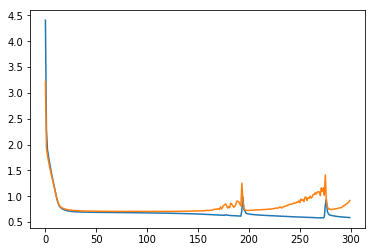

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

## 回測

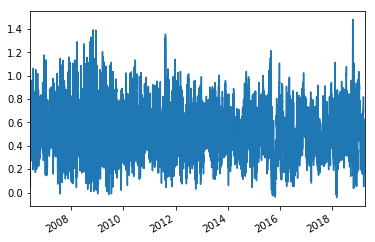

In [14]:
ey = model.predict(X)
ey = pd.Series(ey.swapaxes(0,1)[0], index=indexes)
ey.plot()


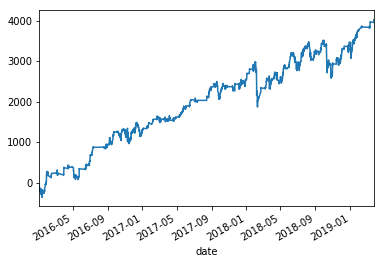

In [15]:
eq = twii[indexes]
returns = (eq.shift(-1) - eq)

signal = (ey > ey.quantile(0.6)).rolling(10).sum() > 0
signal = signal.shift(1).fillna(False)

eq = (returns[signal]['2016':]).cumsum()
eq.plot()

In [16]:
(signal.astype(int).diff().abs().fillna(0) * 3)['2016':].sum()

675.0